In [2]:
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
import os
import pandas as pd

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw
import spikeinterface.sortingcomponents as scpt

In [9]:
#loading the recording
recording_path = "C:/Users/sherman/Documents/Open Ephys/2025-01-30_12-40-48/Record Node 114/experiment1/recording1"
#recordingPXI= se.OpenEphysBinaryRecordingExtractor(recording_path)
recordingNP = se.read_openephys(recording_path, stream_name="Record Node 114#Neuropix-PXI-107.ProbeA")
recordingNIDAQ = se.read_openephys(recording_path, stream_name="Record Node 114#NI-DAQmx-106.PXIe-6341")

In [17]:
trace_NP = recordingNP.get_traces
print(trace_NP)

<bound method BaseRecording.get_traces of OpenEphysBinaryRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 8,998,082 samples 
                                   299.94s (5.00 minutes) - int16 dtype - 6.44 GiB>


In [18]:
print("Neuropixels Recording:")
print(f"  Number of channels: {recordingNP.get_num_channels()}")
print(f"  Number of time samples: {recordingNP.get_num_frames()}")
print(f"  Sampling frequency: {recordingNP.get_sampling_frequency()} Hz")
print(f"  Duration (seconds): {recordingNP.get_num_frames() / recordingNP.get_sampling_frequency():.2f} sec")

print("\nNI-DAQ Recording:")
print(f"  Number of channels: {recordingNIDAQ.get_num_channels()}")
print(f"  Number of time samples: {recordingNIDAQ.get_num_frames()}")
print(f"  Sampling frequency: {recordingNIDAQ.get_sampling_frequency()} Hz")
print(f"  Duration (seconds): {recordingNIDAQ.get_num_frames() / recordingNIDAQ.get_sampling_frequency():.2f} sec")

Neuropixels Recording:
  Number of channels: 384
  Number of time samples: 8998082
  Sampling frequency: 30000.0 Hz
  Duration (seconds): 299.94 sec

NI-DAQ Recording:
  Number of channels: 4
  Number of time samples: 8999000
  Sampling frequency: 30000.0 Hz
  Duration (seconds): 299.97 sec


In [105]:
os.chdir(recording_path)
ttl_path =r'events/NI-DAQmx-106.PXIe-6341/TTL'
os.chdir(ttl_path)

#exploring data structure
timestamps = np.load('timestamps.npy')
channel_states = np.load("states.npy")

# If channel_states is an integer (bit mask), split into individual channels
num_channels = int(np.ceil(np.log2(np.max(channel_states) + 1)))  # Max bits needed
channel_states_binary = ((channel_states[:, None] >> np.arange(num_channels)) & 1)

# Create DataFrame with timestamps and channel states
all_events_df = pd.DataFrame(channel_states_binary, columns=[f'channel_{i}' for i in range(num_channels)])
#print(all_events_df.sum()) #-print(all_events_df.sum()) #-count instances of each ch
all_events_df.insert(0, 'timestam', timestamps)

all_events_Synch=all_events_df[all_events_df["channel_0"]==0]-sync_offset_NIDAQ
print(all_events_Synch)

           timestam  channel_0  channel_1  channel_2
4611      -0.149316 -24.649367 -24.649367 -23.649367
9612       0.350685 -24.649367 -24.649367 -23.649367
14613      0.850718 -24.649367 -24.649367 -23.649367
19613      1.350685 -24.649367 -24.649367 -23.649367
24615      1.850718 -24.649367 -24.649367 -23.649367
...             ...        ...        ...        ...
2975191  296.851136 -24.649367 -24.649367 -23.649367
2980192  297.351175 -24.649367 -24.649367 -23.649367
2985193  297.851138 -24.649367 -24.649367 -23.649367
2990194  298.351176 -24.649367 -24.649367 -23.649367
2995195  298.851140 -24.649367 -24.649367 -23.649367

[599 rows x 4 columns]


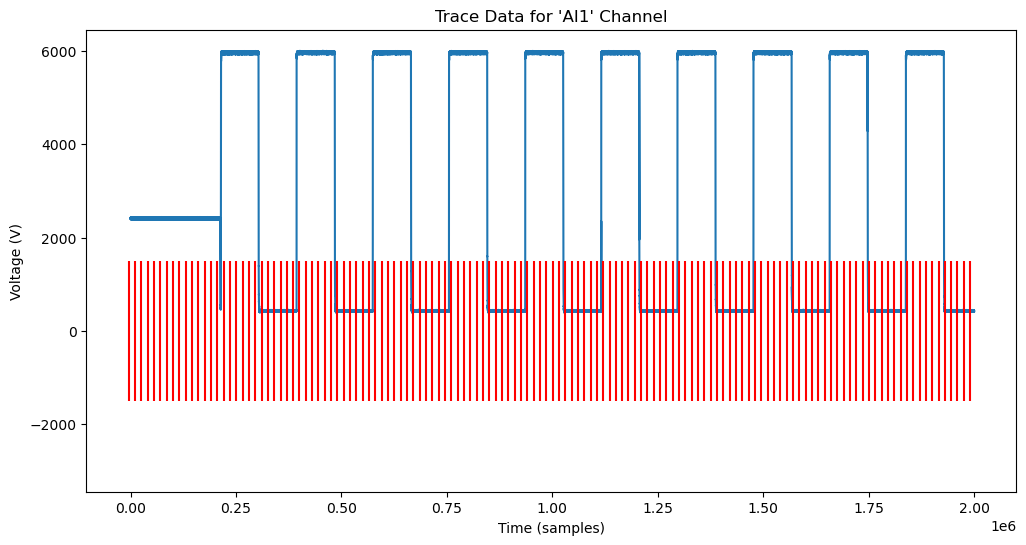

In [115]:
xLimit=2000000
# Get the trace data for 'AI1' (all timepoints)
total_samples = recordingNIDAQ.get_num_frames()  # Total number of samples in the recording

# Extract trace data for 'AI1' for the desired range
trace_data_NIDAQ_single = recordingNIDAQ.get_traces(channel_ids=['AI1'], start_frame=1, end_frame=xLimit)  # Specify range as needed

# Convert to numpy array (if it's not already)
trace_array = np.array(trace_data_NIDAQ_single)

# Plot the continuous data
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(trace_array)
plt.title("Trace Data for 'AI1' Channel")
plt.xlabel("Time (samples)")
plt.ylabel("Voltage (V)")  # Adjust units if needed

# Step 1: Convert event timestamps to samples
sampling_rate = recordingNIDAQ.get_sampling_frequency()  # Hz (30 kHz for your data)
# Assuming all_events_Synch has a column 'timestamps' in seconds, convert to samples
event_timestamps_samples = (all_events_Synch['timestam'] * sampling_rate).astype(int)   # Convert to sample indices

# Step 2: Plot the raster overlay (event timestamps in samples)
plt.eventplot(event_timestamps_samples[event_timestamps_samples < xLimit], orientation='horizontal', colors='r', linelengths=3000)

plt.show()